In [1]:
import torch as t

In [2]:
use_cuda = t.cuda.is_available()
device = t.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [3]:
pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 6.1 MB/s 
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=70395dd11e33d39497f354743f0f7f4d537e083451aa58aabea77cb9de9a75a3
  Stored in directory: /root/.cache/pip/wheels/5b/eb/43/7295e71293b218ddfd627f935229bf54af9018add7fbb5aac6
Successfully built fire


In [4]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import manifold

In [5]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


In [6]:
data_flag = 'octmnist'
download = True

BATCH_SIZE = 128


info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

Read the MedMNIST data, preprocess and encapsulate into dataloader form

In [7]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

  0%|          | 0/54938180 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz


In [8]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset OCTMNIST (octmnist)
    Number of datapoints: 97477
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'choroidal neovascularization', '1': 'diabetic macular edema', '2': 'drusen', '3': 'normal'}
    Number of samples: {'train': 97477, 'val': 10832, 'test': 1000}
    Description: The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset OCTMNIST (octmnist)
    Number of datapoints: 1000
    Root location: /root/.medmnist
    Split: test
    Task:

In [9]:
# visualization

train_dataset.montage(length=1)

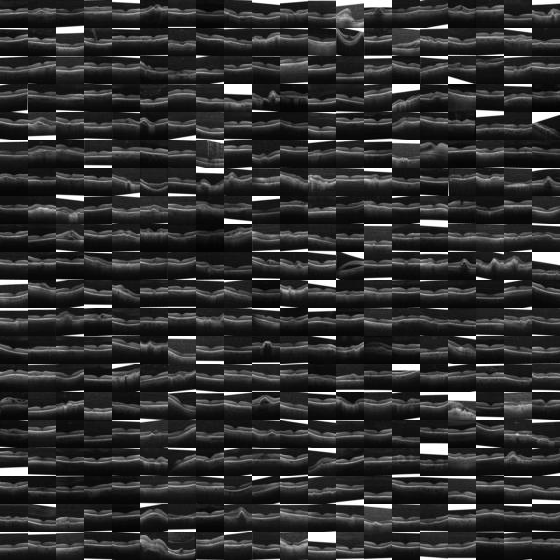

In [10]:
# visualization

train_dataset.montage(length=20)

In [11]:
train_dataset

Dataset OCTMNIST (octmnist)
    Number of datapoints: 97477
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'choroidal neovascularization', '1': 'diabetic macular edema', '2': 'drusen', '3': 'normal'}
    Number of samples: {'train': 97477, 'val': 10832, 'test': 1000}
    Description: The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0

In [12]:
train_dataset.info

{'python_class': 'OCTMNIST',
 'description': 'The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.',
 'url': 'https://zenodo.org/record/6496656/files/octmnist.npz?download=1',
 'MD5': 'c68d92d5b585d8d81f7112f81e2d0842',
 'task': 'multi-class',
 'label': {'0': 'choroidal neovascularization',
  '1': 'diabetic macular edema',
  '2': 'drusen',
  '3': 'normal'},
 'n_channels': 1,
 'n_samples': {'train': 97477, 'val': 10832, 'test': 1000},
 'license': 'CC BY 4.0'}

In [13]:
train_dataset.imgs.shape

(97477, 28, 28)

In [14]:
train_dataset.labels.shape

(97477, 1)

In [15]:
list(train_dataset.info.keys())

['python_class',
 'description',
 'url',
 'MD5',
 'task',
 'label',
 'n_channels',
 'n_samples',
 'license']

In [16]:
x_train = np.array([x.flatten() for x in train_dataset.imgs])
y_train=train_dataset.labels

In [17]:
x_train.shape

(97477, 784)

### Class Imbalance

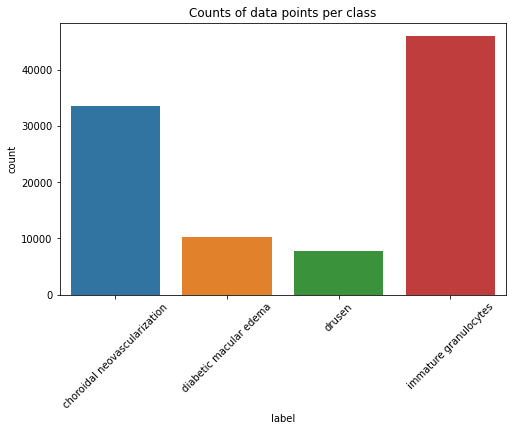

In [18]:
plt.figure(figsize=(8,5))
plt.title('Counts of data points per class')
y_train=pd.DataFrame(y_train)
label_map = train_dataset.info['label']
sns.countplot(x = y_train.iloc[:, 0])
old_xaxis = [int(x) for x in list(label_map.keys())]
new_axis = list(label_map.values())
new_axis[3] = 'immature granulocytes'
plt.xticks(old_xaxis, new_axis, rotation=45)
plt.xlabel('label')
plt.show()

### t-SNE

In [19]:
tsne = manifold.TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(x_train)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 97477 samples in 0.055s...
[t-SNE] Computed neighbors for 97477 samples in 461.724s...
[t-SNE] Computed conditional probabilities for sample 1000 / 97477
[t-SNE] Computed conditional probabilities for sample 2000 / 97477
[t-SNE] Computed conditional probabilities for sample 3000 / 97477
[t-SNE] Computed conditional probabilities for sample 4000 / 97477
[t-SNE] Computed conditional probabilities for sample 5000 / 97477
[t-SNE] Computed conditional probabilities for sample 6000 / 97477
[t-SNE] Computed conditional probabilities for sample 7000 / 97477
[t-SNE] Computed conditional probabilities for sample 8000 / 97477
[t-SNE] Computed conditional probabilities for sample 9000 / 97477
[t-SNE] Computed conditional probabilities for sample 10000 / 97477
[t-SNE] Computed conditional probabilities for sample 11000 / 97477
[t-SNE] Computed conditional probabilities for sample 12000 / 97477
[t-SNE] Computed conditional probabilities for s

In [20]:
x_train=pd.DataFrame(x_train)
y_train=np.array(y_train)

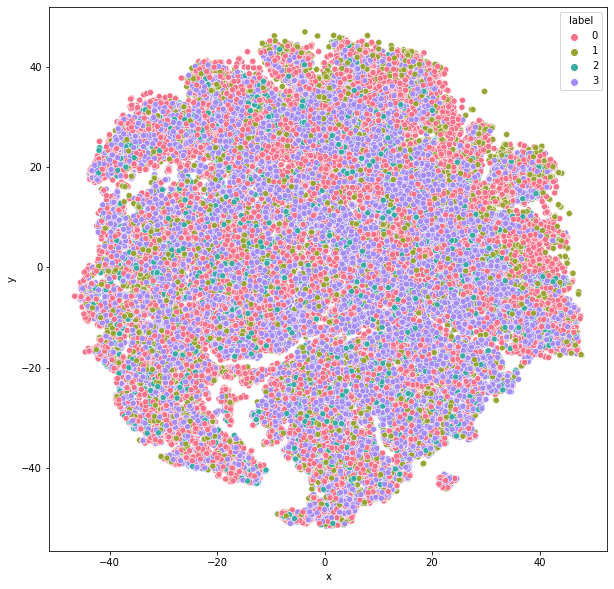

In [22]:
df_tsne= pd.DataFrame(columns = ["x", "y", "label"] )
df_tsne["x"] = tsne[:,0]
df_tsne["y"] = tsne[:,1]
df_tsne["label"] = y_train

plt.figure(figsize = (10,10))
sns.scatterplot(x = df_tsne["x"], y = df_tsne["y"], hue = df_tsne["label"],  palette = sns.color_palette("husl",4))
plt.show()

### PCA

In [23]:
x_train=pd.DataFrame(x_train)
y_train=pd.DataFrame(y_train)

In [24]:
from sklearn.decomposition import PCA

feature_selector = PCA(120, random_state=0)
x_train = feature_selector.fit_transform(x_train)

pca_plot_df = pd.DataFrame(data=x_train[:,0:2], columns=['PC 1', 'PC 2'])
pca_plot_df = pd.concat([pca_plot_df, y_train], axis=1)

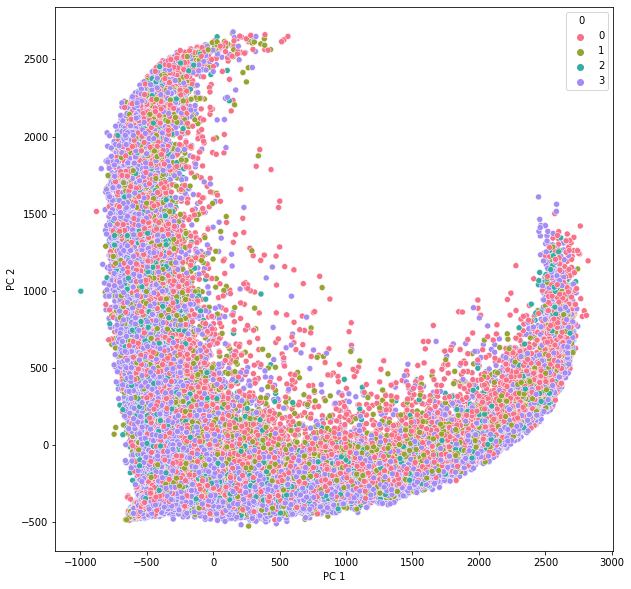

In [26]:
plt.figure(figsize = (10,10))
sns.scatterplot(x = pca_plot_df['PC 1'], y = pca_plot_df['PC 2'], hue = pca_plot_df.iloc[:,2],  palette = sns.color_palette("husl", 4))
plt.show()

### 3D PCA

In [27]:
pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
components = pca.fit_transform(x_train)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y_train.iloc[:, 0],
    title='PCA: '+f'Total Explained Variance is {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [29]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.35104374 0.17951178 0.09064988]


### 3D t-SNE

In [ ]:
import plotly.express as px

tsne_components = manifold.TSNE(n_components=3, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(x_train)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 97477 samples in 0.018s...


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computed neighbors for 97477 samples in 190.359s...
[t-SNE] Computed conditional probabilities for sample 1000 / 97477
[t-SNE] Computed conditional probabilities for sample 2000 / 97477
[t-SNE] Computed conditional probabilities for sample 3000 / 97477
[t-SNE] Computed conditional probabilities for sample 4000 / 97477
[t-SNE] Computed conditional probabilities for sample 5000 / 97477
[t-SNE] Computed conditional probabilities for sample 6000 / 97477
[t-SNE] Computed conditional probabilities for sample 7000 / 97477
[t-SNE] Computed conditional probabilities for sample 8000 / 97477
[t-SNE] Computed conditional probabilities for sample 9000 / 97477
[t-SNE] Computed conditional probabilities for sample 10000 / 97477
[t-SNE] Computed conditional probabilities for sample 11000 / 97477
[t-SNE] Computed conditional probabilities for sample 12000 / 97477
[t-SNE] Computed conditional probabilities for sample 13000 / 97477
[t-SNE] Computed conditional probabilities for sample 14000 / 974

In [ ]:
fig = px.scatter_3d(
    tsne_components, x=0, y=1, z=2, color=y_train.iloc[:, 0],
    title='tSNE',
    labels={'0': 'x', '1': 'y', '2': 'z'}
)
fig.show()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
x_train=pd.DataFrame(x_train)
x_train.shape

In [ ]:
y_train=pd.DataFrame(y_train)
y_train.shape

In [ ]:
y_train

In [ ]:
def get_class_arrays(class_index):
    x = x_train[y_train.iloc[:, 0] == class_index]
    y=y_train[y_train.iloc[:, 0] == class_index]
    return x,y

In [ ]:
number_classes=4

In [ ]:
figure = plt.figure(figsize=(25,5))

def get_histogram():
    for i in range(number_classes):
        class_arrayX,class_arrayY = get_class_arrays(i)
        plt.subplot(2,5,i+1)
        _ = plt.hist(class_arrayX)
        plt.title(i)
get_histogram()

In [ ]:
def get_mean_barchart():
    mean_values =[]
    for i in range(number_classes):
        class_arrayX,class_arrayY = get_class_arrays(i)
        mean_values.append(class_arrayX.mean().mean())
    plt.bar(np.arange(number_classes),mean_values, align='center')
    plt.xticks(np.arange(number_classes))

get_mean_barchart()

In [ ]:
embeddings =embeddings =manifold.TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(x_train)

UNDERSTAND: https://medium.com/datadl-ai/mnist-exploration-to-execution-25136ca00570

In [ ]:
def get_class_embeddings_arrays(class_index):
    x = embeddings[y_train.iloc[:, 0] == class_index]
    y=y_train[y_train.iloc[:, 0] == class_index]
    return x,y

In [ ]:
figure = plt.figure(figsize=(20,7))

for i in range(number_classes):
    plt.subplot(2,5,i+1)
    class_embeddings_arrayX,class_embeddings_arrayY = get_class_embeddings_arrays(i)
    plt.scatter(class_embeddings_arrayX[:, 0], class_embeddings_arrayX[:, 1], c=class_embeddings_arrayY, 
                cmap=plt.cm.get_cmap("jet", 10), marker='.')
    plt.clim(-0.5, 9.5)
    plt.axis([-40, 40, -40, 40])
    plt.title(i)

In [ ]:
pip install bokeh

In [ ]:
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
output_notebook()

In [ ]:
df=pd.DataFrame(x_train)
df['label']=y_train.astype('str')

In [ ]:
df = df.astype(str)

In [ ]:
df.head()

In [ ]:
# define hover tool
from bokeh.models import HoverTool
hover = HoverTool(
    # we print the class label 
    # and the index in the dataframe
    # in the tooltip
    tooltips = [('label','@label'),
               ('index', '$index')]
)

# create figure
fig_scat = figure(tools=[hover, 'box_zoom', 'crosshair', 'undo'], 
                  width=600)

# bokeh data source from the dataframe
source = ColumnDataSource(df)


In [ ]:

# color definition
from bokeh.transform import linear_cmap
from bokeh.palettes import d3
from bokeh.models import CategoricalColorMapper
palette = d3['Category10'][4]
cmap = CategoricalColorMapper(
    factors=df['label'].unique(),
    palette=palette
)

# scatter plot in figure
fig_scat.scatter(
    x='x', y='y', alpha=0.5, 
    color={'field': 'label', 'transform': cmap}, 
    source=source
)

# display below
show(fig_scat)